# Episode 5: Statistical Analysis
## 5.1. ROI driven analysis with Nilearn
## 5.1.1. Volumetric Atlases

In [1]:
import os
import numpy   as np
import nibabel as nib
import nilearn
import nipype
import matplotlib.pyplot as plt

from nilearn import plotting
tutorial_root = os.getcwd()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


### 5.1.1.1. Visualizing anatomical atlases
### 🧠 Cortical atlas parcellations
Brain atlases are used for identifying regions of interest, often required to obtain statistical inferences in neuroimaging. Parcellation of such units in the cortex is achieved using cortical atlases. The use of a few commonly used cortical atlases is demonstrated in this section.

In [2]:
from nilearn import datasets

### ▪️ Visualizing the Automated Anatomical Labeling (AAL)  atlas
The AAL atlaswidely used for cortical parcellation. Related citations: <a href="https://pubmed.ncbi.nlm.nih.gov/11771995/" target="_blank">*Tzourio-Mazoyer 2002*</a>. \
Updated versions, AAL2 and AAL3, has been released in 2015 and 2019 respectively. (Related information can be found on <a href="https://www.gin.cnrs.fr/en/tools/aal/" target="_blank">this page</a>.).

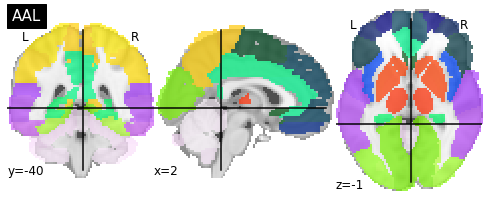

In [3]:
dataset = datasets.fetch_atlas_aal('SPM12')
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="AAL")

### ▪️ Visualizing Yeo 2011 functional parcellations (Yeo 2011)
Atlas based on 1000 subjects exhibiting co-activations of the brain. Two versions are available that include 7 vs. 17 neworks. There are 7 labels in the original Yeo atlas, that is indicated in the colorbar. These 7 labels correspond to networks that comprise several regions. \
Related citations: <a href="https://journals.physiology.org/doi/full/10.1152/jn.00338.2011" target="_blank">*Yeo 2011*</a>.

In [4]:
#dataset   = datasets.fetch_atlas_yeo_2011()
#atlas_yeo = dataset.thick_7
#plotting.plot_roi(atlas_yeo, title="Yeo 2011")

### ▪️ Visualizing the Local-Global Parcellation of the Human Cerebral Cortex (Schaefer 2018)
These novel parcellations add further refinement by subparcellating the global networks based on a local gradient approach, based on the work by Thomas Yeo, 2011 (visualized above). Parcellations come in several versions, breaking down the cortex into up to 1000 regions.

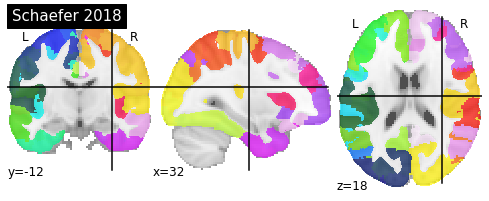

In [5]:
dataset = datasets.fetch_atlas_schaefer_2018()
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="Schaefer 2018")

# By default, the number of ROIs is 400 and  and ROI annotations according neo networks is 7.
# This may be changed by changing the inputs to the function as below.
# nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)

### ▪️ Visualizing the Harvard-Oxford atlas

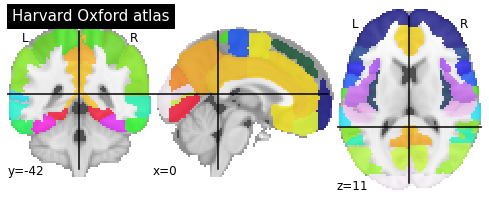

In [6]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

### 🧠 Subcortical atlas parcellations

### ▪️ Visualizing CIT168 Reinforcement Learning Atlas
This atlas is often used in work that study brain structures involved in reinforcement learning processes.\
Related citations: <a href="https://www.nature.com/articles/sdata201863" target="_blank">*Pauli 2017*</a>. 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nilearn/plotting/displays.py:103: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/nilearn/plotting/displays.py:103: UserWarning: linewidths is ignored by contourf
  **kwargs)


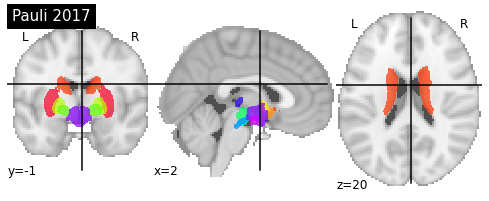

In [7]:
dataset = datasets.fetch_atlas_pauli_2017()
atlas_filename = dataset.maps 
plotting.plot_prob_atlas(atlas_filename, title="Pauli 2017")

### 5.1.1.2. Regional volumetric analysis

Structural properties or anatomical characteristics of ROIs can be used to further our understanding on underlying abnormalities. For this, ROIs are segmented using suitable software for ROI analysis. 
In this case, we consider segmentation of a single image using FreeSurfer and FSL, two commonly used software.

### ▪️ Using FSL to segment a region of interest

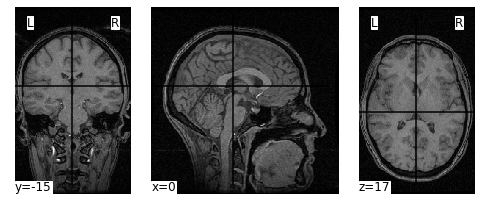

In [8]:
import shutil

# Anatomical image from the haxby_dataset is loaded
# It is then saved to the current working directory
haxby_dataset = datasets.fetch_haxby()
anat_file     = haxby_dataset.anat[0]

# Make a new directory for FSL segmentation is not available
# Go to new directory - working direcotry
if not os.path.isdir('FSLseg'):
    os.mkdir('FSLseg')

os.chdir(os.path.join(os.getcwd(),'FSLseg'))
shutil.copyfile(anat_file,os.path.join(os.getcwd(),'structural.nii.gz'))

# We can then use the .nii.gz we will be processing
plotting.plot_img(anat_file,cmap='gray')

In [9]:
from nipype.interfaces import fsl
import itk

In [11]:
#run FSL first to segment the reguired segmentations
#For now we only focus on the left hippocampus
first = fsl.FIRST()
first.inputs.in_file  = 'structural.nii.gz'
first.inputs.out_file = 'segmented.nii.gz'

# Can be removed or commented if all regions need to be segmented
first.inputs.list_of_specific_structures=['L_Hipp'] 

res = first.run()

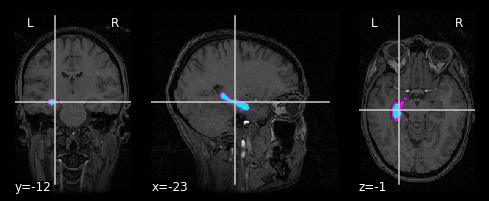

In [12]:
# Load T1w image and segmented labels
# Then overlay and view output
T1w_img   = nib.load('structural.nii.gz')
seg_labels= nib.load('segmented-L_Hipp_first.nii.gz')

plotting.plot_roi(roi_img=seg_labels, bg_img=T1w_img, alpha=0.9, cmap="cool",dim=-.5);

In [13]:
import nibabel.imagestats as imagestats
# Volume of the Left hippocampus
imagestats.mask_volume(nib.Nifti1Image(seg_labels.get_fdata(), np.eye(4)))

4189.0

Segmenting for all structures...

In [15]:
first = fsl.FIRST()
first.inputs.in_file  = 'structural.nii.gz'
first.inputs.out_file = 'segmented_allROIs.nii.gz'

resAll = first.run()

In [20]:
T1w_img      = nib.load('structural.nii.gz')
seg_labelsAll= nib.load('segmented_allROIs_all_fast_firstseg.nii.gz')

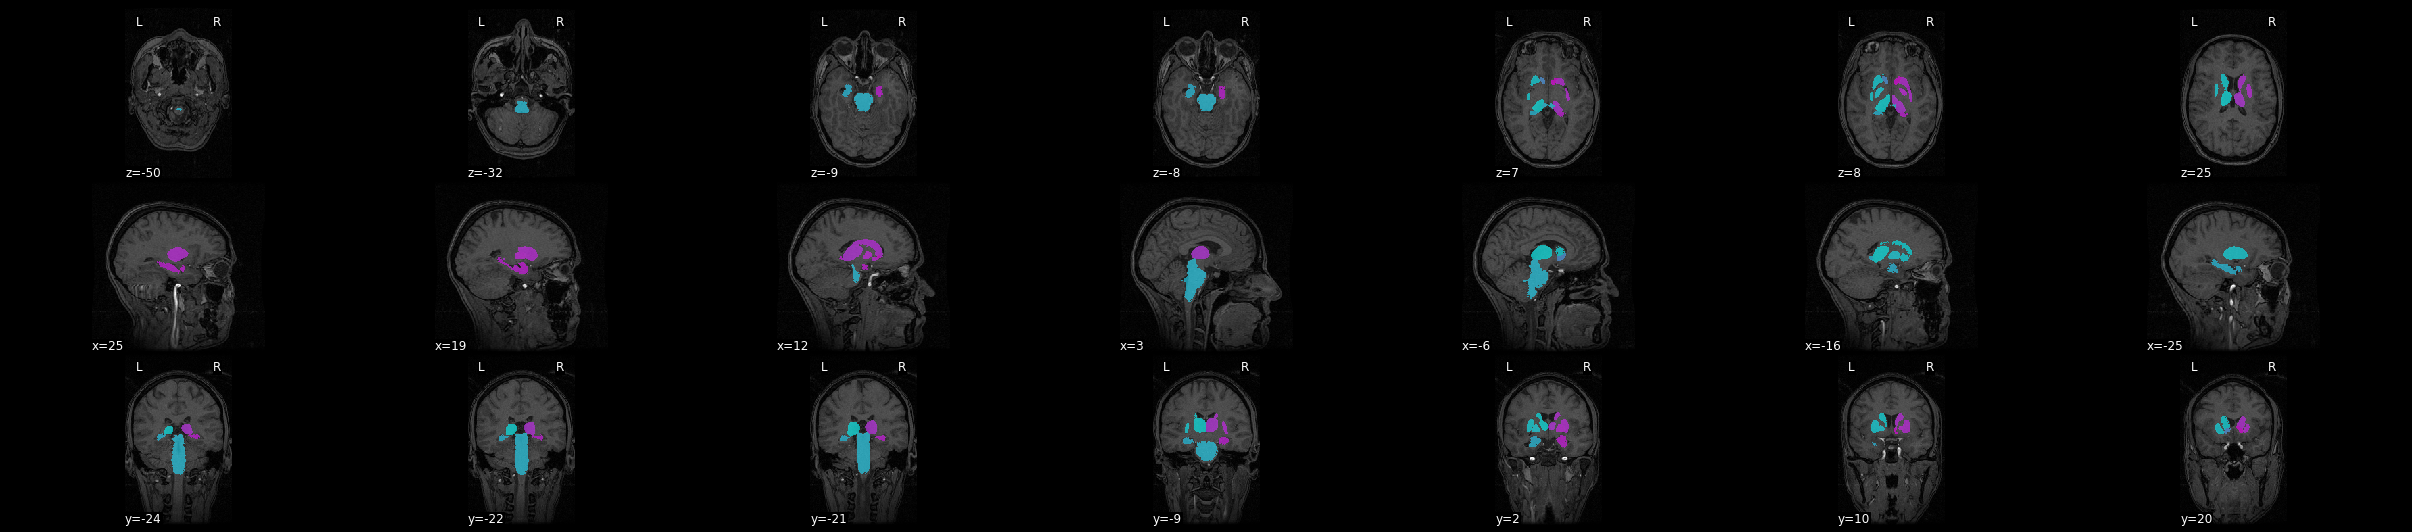

In [21]:
plotting.plot_roi(roi_img=seg_labelsAll, bg_img=T1w_img, alpha=0.6, cmap="cool",display_mode='mosaic',dim=-0.5)

### ▪️ Using FreeSurfer for volumetric Analysis
Freesurfer ReconAll can be used to get all segmentations and stats. Can be achieved using steps given in the [nipype beginner's guide](https://miykael.github.io/nipype-beginner-s-guide/prepareData.html).
        This takes a considerably long time to execute. Therefore, a directory containing ```recon-all``` outputs from a single subject ```sub001``` is made available for download through [this link]((https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/devdinie/sMRI_StatisticalAnalysis/tree/main/5_OtherFiles/sub001_ReconAll)).

In [24]:
# Make a new directory for FSL segmentation is not available
# Go to new directory - working direcotry
# Provided freesurfer outputs for sub001 extracted to new working directory

from subprocess import check_output

if not os.path.isdir('FSseg') and not os.path.basename(os.getcwd())=='FSseg':
    os.mkdir('FSseg')

os.chdir(os.path.join(tutorial_root,'FSseg'))

In [25]:
#aseg_stats=os.path.join('/Users/swapna/DataCarpentry_sMRI/FSseg/sub001/stats/aseg.stats')
aseg_stats_path=os.path.join(os.getcwd(),'sub001/stats/aseg.stats')
aseg_stats     = np.loadtxt(aseg_stats_path, dtype="i1,i1,i4,f4,S32,f4,f4,f4,f4,f4")
aseg_stats

array([( 1,  4,  8744, 9.09630e+03, b'Left-Lateral-Ventricle',  20.6608, 13.8154,  0.,  84.,  84.),
       ( 2,  5,   518, 5.52900e+02, b'Left-Inf-Lat-Vent',  34.8359, 16.1599,  0.,  83.,  83.),
       ( 3,  7, 13969, 1.48399e+04, b'Left-Cerebellum-White-Matter',  81.6983,  8.4093, 13., 106.,  93.),
       ( 4,  8, 55942, 5.59028e+04, b'Left-Cerebellum-Cortex',  52.5322, 12.5234,  0., 130., 130.),
       ( 5, 10,  8452, 8.15100e+03, b'Left-Thalamus-Proper',  83.3055, 10.4368, 22., 109.,  87.),
       ( 6, 11,  4308, 4.34240e+03, b'Left-Caudate',  71.5796,  7.8064, 38.,  99.,  61.),
       ( 7, 12,  5426, 5.42390e+03, b'Left-Putamen',  80.4724,  6.3367, 48., 106.,  58.),
       ( 8, 13,  2156, 2.10520e+03, b'Left-Pallidum',  95.1702,  5.3659, 71., 111.,  40.),
       ( 9, 14,  1137, 1.19050e+03, b'3rd-Ventricle',  28.4362, 15.0361,  2.,  78.,  76.),
       (10, 15,  3585, 3.72130e+03, b'4th-Ventricle',  14.128 , 10.0585,  0.,  65.,  65.),
       (11, 16, 19987, 2.01286e+04, b'Brain-Stem

#### Volumetric Analysis: ROI differences in Young, Middle Aged, Nondemented and Demented Older Adults

The summarized freesurfer outputs from the OASIS1 dataset can be downloaded [here](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_extras/5_OtherFiles/OASIS_FS_ASEG.csv). This dataset contains FreeSurfer outputs for scans of young, middle aged, and older adults.Older adults who are demented at the time of scanning and those who are progressing have been given a Clinical Dementia Rating (CDR).

We can observe the ROI volumetric differences in adults and how these volumes vary based on their CDR. For this example, we consider 6 regions of interest: Left/Right Amygdala, Hippocampus and Lateral ventricle.

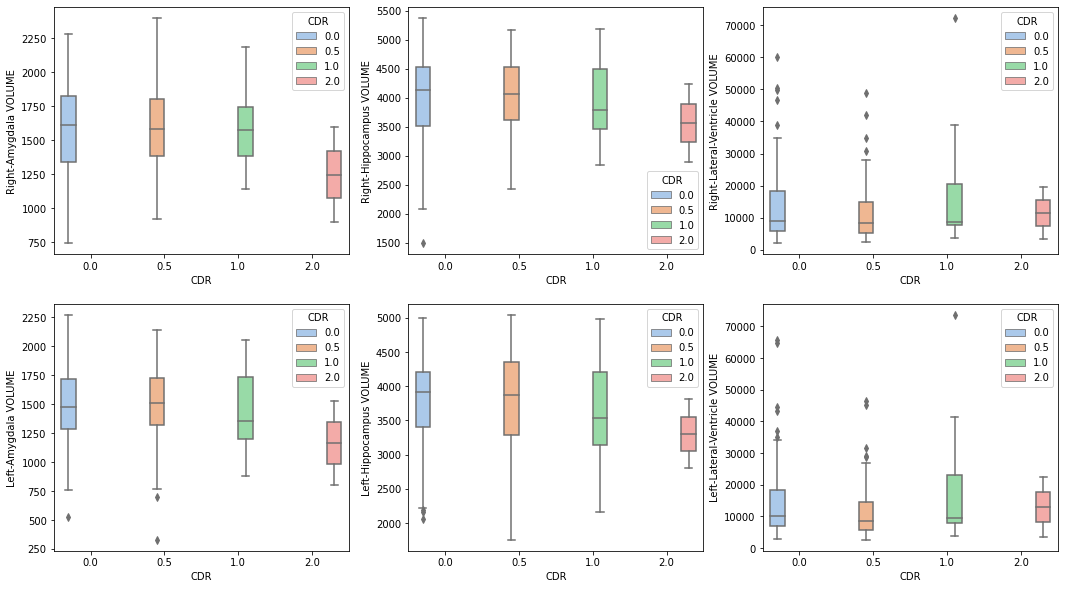

In [26]:
import pandas as pd
import seaborn as sns
oasis_aseg = pd.read_csv("/Users/swapna/DataCarpentry_sMRI/OASIS_FS_ASEG.CSV")

#Set current working directory to where you downloaded the .csv files
os.chdir(tutorial_root)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sns.boxplot(ax=axes[0, 0], data=oasis_aseg, x='CDR', y='Right-Amygdala VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[0, 1], data=oasis_aseg, x='CDR', y='Right-Hippocampus VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[0, 2], data=oasis_aseg, x='CDR', y='Right-Lateral-Ventricle VOLUME',hue='CDR',palette='pastel')

sns.boxplot(ax=axes[1, 0], data=oasis_aseg, x='CDR', y='Left-Amygdala VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[1, 1], data=oasis_aseg, x='CDR', y='Left-Hippocampus VOLUME',hue='CDR',palette='pastel')
sns.boxplot(ax=axes[1, 2], data=oasis_aseg, x='CDR', y='Left-Lateral-Ventricle VOLUME',hue='CDR',palette='pastel')

#### Cohen's D effect size for selected ROIs in adults over 60 years of age
For simplicity, an updated .csv file has been uploaded separately [here](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_extras/5_OtherFiles/OASIS_FS_ASEG_OVER60.csv). In this subset of data, older adults who had a CDR score>0 was considered to be demented or progressing towards dementia.
The effect size is calculated between two groups: healthy adults and those who show signs of AD.

In [27]:
oasis_aseg_60 = pd.read_csv("/Users/swapna/DataCarpentry_sMRI/OASIS_FS_ASEG_OVER60new.CSV")

See Exercise 5.2. in [episode 5](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_episodes/05-Statistical_Analysis.md). The resulting output was as shown below.

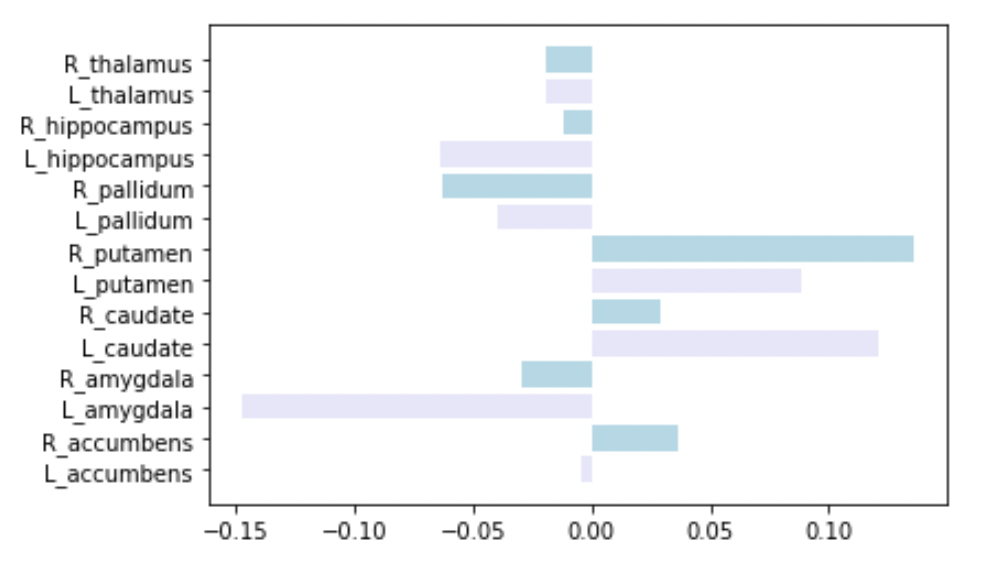

In [28]:
from IPython import display
display.Image("/Users/swapna/Desktop/Visualization/5_EffectSize.png", width = 450, height = 225)

## 5.1.2. Cortical surface parcellations
### 5.1.2.1. Visualizing cortical surface parcellations
### 🧠 Cortical surface parcellations

### ▪️ Visualizing the Destrieux atlas
A parcellation scheme widely used in the freesurfer world based on sulcal depth and yielding precise automated definition of cortical gyri and sulci. \ 
Related citations: Related citations: <a href="https://www.sciencedirect.com/science/article/abs/pii/S1053811910008542?via%3Dihub" target="_blank">*Destrieux 2010*</a>. 

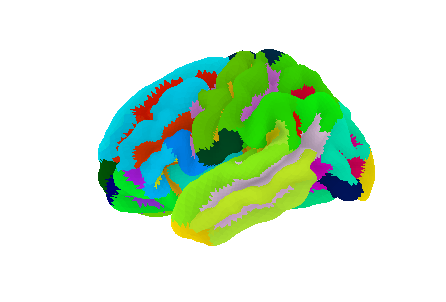

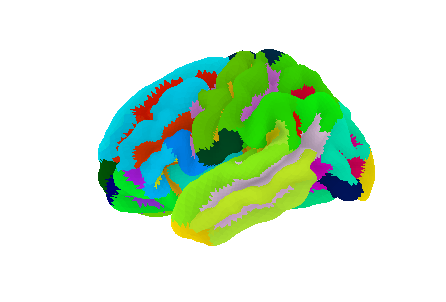

In [29]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# Lateral view is observed in this example.
# Other views (e.g. posterior, ventral may also be used)
plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=parcellation,hemi='left', 
                       view='lateral',bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=.5)

### 5.1.2.2. Cortical thickness analysis
### 🧠 Regional cortical thickness analysis

A .csv file containing cortical thickness values from Freesurfer ```recon-all``` outputs file can be downloaded [here](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_extras/5_OtherFiles/cortical_thickness_results.csv).

In [30]:
import pandas as pd

os.chdir(tutorial_root)
if not os.path.isdir('CT_analysis'):
    os.mkdir('CT_analysis')
os.chdir(os.path.join(tutorial_root,'CT_analysis'))

In [31]:
SCZ_CT = pd.read_csv("cortical_thickness_results.csv")
SCZ_CT = SCZ_CT.dropna() # remove rows if a values is not available

In [32]:
import pandas as pd
import seaborn as sns

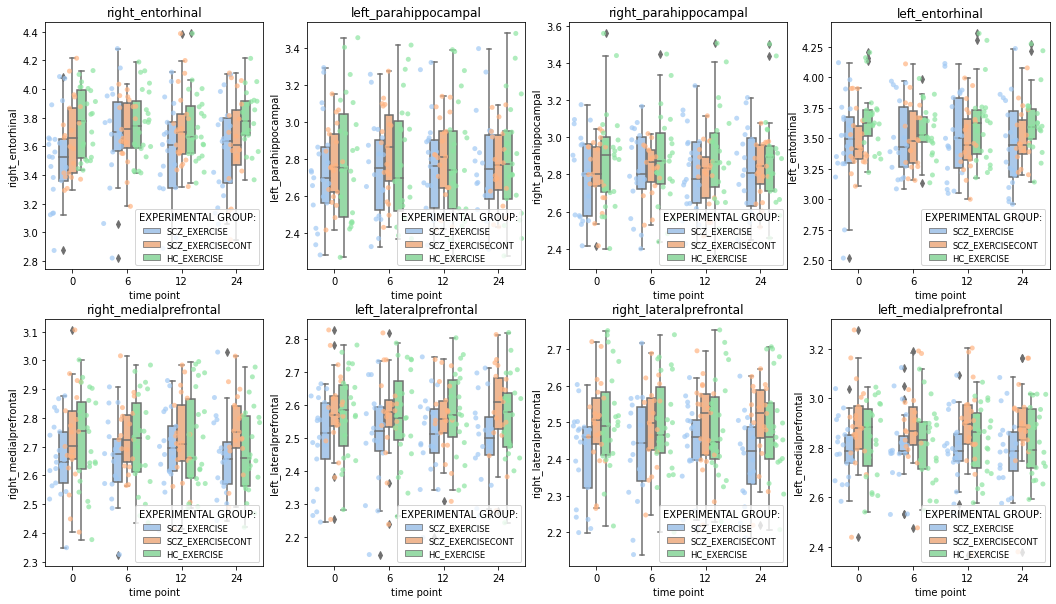

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
row=0; colm=3
for col in range(3,11): 
    colm=col-2
    if col>6: row=1; colm=colm-4
    
    sns.boxplot(ax=axes[row, colm-2],x='time point', y=SCZ_CT.columns.tolist()[col], 
                width=0.5, data=SCZ_CT, hue='Experimental_group', 
                palette='pastel').set(xlabel='Time point/weeks', ylabel='Cortical thickness/mm',title=SCZ_CT.columns.tolist()[col])
    
    sns.stripplot(ax=axes[row, colm-2],x='time point', y=SCZ_CT.columns.tolist()[col], data=SCZ_CT, 
                  hue='Experimental_group',jitter=0.5, dodge=True,alpha=0.7,palette='pastel')

    h, l = axes[row, colm-2].get_legend_handles_labels()
    axes[row, colm-2].legend(h, ['SCZ_EXERCISE', 'SCZ_EXERCISECONT','HC_EXERCISE'], title="EXPERIMENTAL GROUP:", loc='lower right',fontsize='small')
    

In [34]:
SCZ_CT

,Experimental_group,Group_ID,time point,left_entorhinal,right_entorhinal,left_parahippocampal,right_parahippocampal,left_medialprefrontal,right_medialprefrontal,left_lateralprefrontal,right_lateralprefrontal
0,SCZ_EXERCISE,1,0,3.981,3.622,2.876,2.963,2.960,2.837,2.651,2.586
1,SCZ_EXERCISE,2,0,3.296,3.360,2.688,2.817,2.737,2.752,2.478,2.394
2,SCZ_EXERCISE,3,0,3.524,3.918,2.552,2.549,2.811,2.631,2.515,2.370
3,SCZ_EXERCISE,4,0,3.292,3.453,2.597,2.683,2.852,2.518,2.561,2.459
4,SCZ_EXERCISE,5,0,3.606,3.560,2.282,2.571,2.823,2.687,2.650,2.603
...,...,...,...,...,...,...,...,...,...,...,...
253,HC_EXERCISE,17,24,3.625,3.921,3.346,3.437,2.729,2.735,2.620,2.553
254,HC_EXERCISE,18,24,3.743,3.854,2.946,2.885,2.962,2.977,2.698,2.700
255,HC_EXERCISE,19,24,3.429,3.366,2.774,2.897,2.724,2.672,2.571,2.498
256,HC_EXERCISE,20,24,3.296,3.712,2.707,2.804,2.880,2.651,2.615,2.391


Mean cortical thickness across the subjects for each group at each time point (Exercise 5.2-(a) in [episode 5](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_episodes/05-Statistical_Analysis.md)).
A similar approach can be used to get CT values for other ROIs as well.

In [35]:
ROIdf_byGroup = SCZ_CT[['Experimental_group','time point','left_entorhinal']]
ROIdf_avg_byGroup = ROIdf_byGroup.groupby(['Experimental_group', 'time point']).mean()
ROIdf_avg_byGroup

left_entorhinal
Experimental_group time point                 
HC_EXERCISE        0                  3.656739
                   6                  3.561957
                   12                 3.614609
                   24                 3.638286
SCZ_EXERCISE       0                  3.468381
                   6                  3.497444
                   12                 3.524476
                   24                 3.447300
SCZ_EXERCISECONT   0                  3.477952
                   6                  3.526737
                   12                 3.495429
                   24                 3.479895

Entorhinal cortex cortical thickness for each subject plotted over 4 time points for schizophrenia group with exercise (SCZ_EXERCISE). A similar approach can be used to get CT values for other ROIs as well. ((Exercise 5.2-(b)-i in [episode 5](https://github.com/carpentries-incubator/SDC-BIDS-sMRI/tree/gh-pages/_episodes/05-Statistical_Analysis.md)))

In [36]:
ROIdf_entL=SCZ_CT[['Experimental_group','Group_ID','time point','left_entorhinal']]

ROIdf_entL_grouped = ROIdf_entL.groupby('Experimental_group')    
[ROIdf_entL_grouped.get_group(x) for x in ROIdf_entL_grouped.groups]

SCZ_EXERCISE_CT = pd.DataFrame(ROIdf_entL_grouped.get_group('SCZ_EXERCISE'))
SCZ_EXERCISE_CT

,Experimental_group,Group_ID,time point,left_entorhinal
0,SCZ_EXERCISE,1,0,3.981
1,SCZ_EXERCISE,2,0,3.296
2,SCZ_EXERCISE,3,0,3.524
3,SCZ_EXERCISE,4,0,3.292
4,SCZ_EXERCISE,5,0,3.606
...,...,...,...,...
210,SCZ_EXERCISE,16,24,3.476
211,SCZ_EXERCISE,17,24,3.005
212,SCZ_EXERCISE,18,24,2.980
213,SCZ_EXERCISE,19,24,4.237


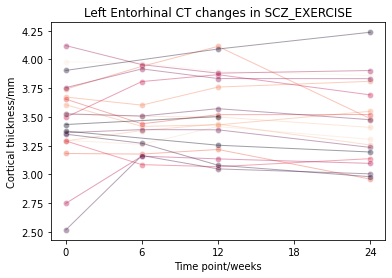

In [37]:
entL_CT_SCZEXERCISE = sns.lineplot(data=SCZ_EXERCISE_CT, x='time point', y='left_entorhinal',marker="o",
                                   hue='Group_ID', palette='rocket_r', alpha=0.4,estimator=None, color='thistle',
                                   lw=1,legend=False).set(xlabel="Time point/weeks", ylabel = "Cortical thickness/mm",
                                                          title='Left Entorhinal CT changes in SCZ_EXERCISE',
                                                          xticks=[0,6,12,18,24])

Mean cortical thickness in the Entorhinal cortex across all subjects in the schizophrenia group with exercise (SCZ_EXERCISE), over 4 time points.

In [38]:
ROIdf_avgEntCT = pd.DataFrame(ROIdf_avg_byGroup.groupby('Experimental_group').get_group('SCZ_EXERCISE'))
ROIdf_avgEntCT

left_entorhinal
Experimental_group time point                 
SCZ_EXERCISE       0                  3.468381
                   6                  3.497444
                   12                 3.524476
                   24                 3.447300

In [ ]:
entL_CT_SCZEXERCISE = sns.lineplot(data=SCZ_EXERCISE_CT, x='time point', y='left_entorhinal',marker="o",
                                   hue='Group_ID', palette='rocket_r', alpha=0.4,estimator=None, color='thistle',
                                   lw=1,legend=False).set(xlabel="Time point/weeks", ylabel = "Cortical thickness/mm",
                                                          title='Left Entorhinal CT changes in SCZ_EXERCISE',
                                                          xticks=[0,6,12,18,24])
plt.plot((0,6,12,24),np.array(ROIdf_avgEntCT['left_entorhinal']),marker='p',color='darkblue',linestyle='dashed')
plt.show() #Add mean value(dashed line)

## 5.2. Voxel Based Morphometry (VBM)
In a nutshell, VBM is the voxel-wise comparison of the local concentration of gray matter between two groups of subjects.

### 🧠 Preprocessing for VBM

The process using SPM mainly involves three steps: 1. Using NewSegment 2. Using DARTEL 3. Normlizing to MNI space.

In [39]:
os.chdir(tutorial_root)
if not os.path.isdir('VBM'):
    os.mkdir('VBM')

os.chdir(os.path.join(tutorial_root,'VBM'))

In [46]:
import nipype
import nipype.interfaces.spm    as spm
import nipype.interfaces.matlab as matlab

spm.SPMCommand.set_mlab_paths(paths='/Users/swapna/DataCarpentry_sMRI/VBM/spm12/', 
                              matlab_cmd='/Applications/MATLAB_R2021a.app/bin/matlab -nodesktop -nosplash')

**1. Using NewSegment**

To observe the outputs over these tasks, we have used a single T1w image ```structural.nii```.

In [49]:
seg = spm.NewSegment()
seg.inputs.channel_files = 'structural.nii'

tissue1 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii'  , 1), 2, (True,True)  , (False, False))
tissue2 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii' , 2), 2, (True,True)  , (False, False))
tissue3 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii' , 3), 2, (True,False) , (False, False))
tissue4 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii' , 4), 2, (False,False), (False, False))
tissue5 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii' , 5), 2, (False,False), (False, False))

In [50]:
seg.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5]
seg.run() 

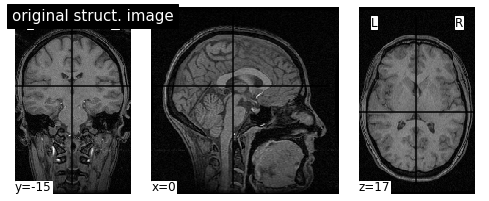

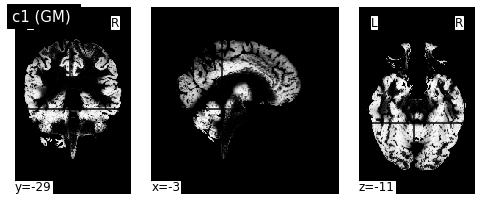

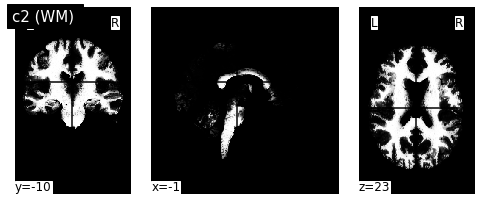

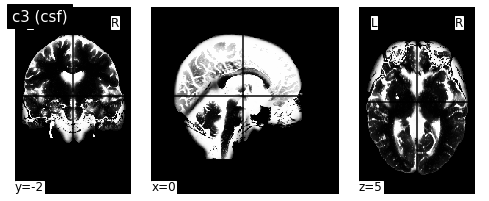

In [51]:
in_NewSeg = nib.load('structural.nii')
c1_NewSeg = nib.load('c1structural.nii')
c2_NewSeg = nib.load('c2structural.nii')
c3_NewSeg = nib.load('c3structural.nii')

fig.add_subplot(1, 1, 1) ; plotting.plot_img(in_NewSeg,cmap='gray',display_mode='ortho',title='original struct. image')
fig.add_subplot(1, 2, 2) ; plotting.plot_img(c1_NewSeg,cmap='gray',display_mode='ortho',title='c1 (GM) ')
fig.add_subplot(1, 3, 3) ; plotting.plot_img(c2_NewSeg,cmap='gray',display_mode='ortho',title='c2 (WM) ')
fig.add_subplot(1, 4, 4) ; plotting.plot_img(c3_NewSeg,cmap='gray',display_mode='ortho',title='c3 (csf)')

In [52]:
os.chdir(os.path.join(tutorial_root,'VBM'))
if not os.path.isdir('DARTEL'):
    os.mkdir('DARTEL')

os.chdir(os.path.join(tutorial_root,'VBM','DARTEL'))

spm.SPMCommand.set_mlab_paths(paths=os.path.join('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/'), 
                              matlab_cmd='/Applications/MATLAB_R2021a.app/bin/matlab -nodesktop -nosplash')

In [53]:
#The directory DARTEL contains two .nii images: structural_1 and structural_2

seg1 = spm.NewSegment()
seg1.inputs.channel_files = 'structural_1.nii'

tissue1 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 1), 2, (True,True)  , (False, False))
tissue2 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 2), 2, (True,True)  , (False, False))
tissue3 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 3), 2, (True,False) , (False, False))
tissue4 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 4), 2, (False,False), (False, False))
tissue5 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 5), 2, (False,False), (False, False))

seg1.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5]
seg1.run() 

In [55]:
seg2 = spm.NewSegment()
seg2.inputs.channel_files = 'structural_2.nii'

tissue1 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 1), 2, (True,True)  , (False, False))
tissue2 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 2), 2, (True,True)  , (False, False))
tissue3 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 3), 2, (True,False) , (False, False))
tissue4 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 4), 2, (False,False), (False, False))
tissue5 = (('/Users/swapna/DataCarpentry_sMRI/VBM/spm12/tpm/TPM.nii', 5), 2, (False,False), (False, False))

seg2.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5]
seg2.run() 

In [56]:
rc1_NewSeg1 = nib.load('rc1structural_1.nii')
rc2_NewSeg1 = nib.load('rc2structural_1.nii')

rc1_NewSeg2 = nib.load('rc1structural_2.nii')
rc2_NewSeg2 = nib.load('rc2structural_2.nii')

dartel = spm.DARTEL()
dartel.inputs.image_files = [['rc1structural_1.nii','rc1structural_2.nii'],['rc2structural_1.nii', 'rc2structural_2.nii']]
dartel.run()

Non-finite values detected. These values will be replaced with zeros.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


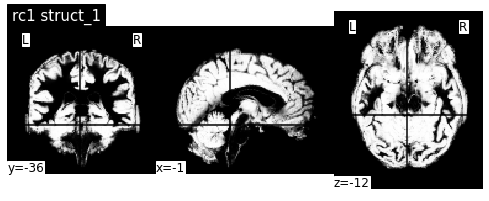

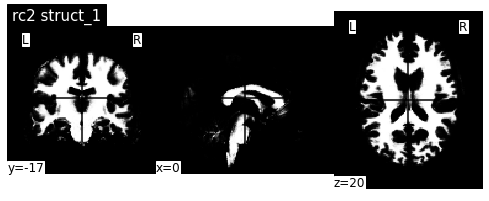

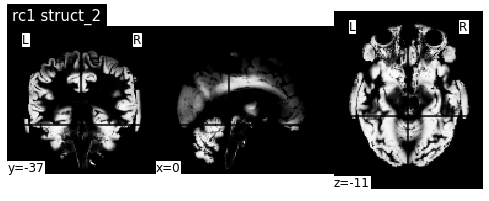

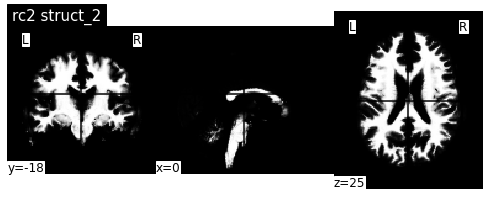

In [57]:
fig.add_subplot(1, 2, 1) ; plotting.plot_img(rc1_NewSeg1,cmap='gray',display_mode='ortho',title='rc1 struct_1')
fig.add_subplot(1, 2, 2) ; plotting.plot_img(rc2_NewSeg1,cmap='gray',display_mode='ortho',title='rc2 struct_1')
fig.add_subplot(1, 2, 1) ; plotting.plot_img(rc1_NewSeg2,cmap='gray',display_mode='ortho',title='rc1 struct_2')
fig.add_subplot(1, 2, 2) ; plotting.plot_img(rc2_NewSeg2,cmap='gray',display_mode='ortho',title='rc2 struct_2')

In [58]:
urc1_dartel_1 = nib.load('u_rc1structural_1_Template.nii')
urc1_dartel_2 = nib.load('u_rc1structural_2_Template.nii')

c1_structural_1 = nib.load('c1structural_1.nii')
c1_structural_2 = nib.load('c1structural_2.nii')

nm = spm.DARTELNorm2MNI()

nm.inputs.template_file   = 'Template_6.nii'
nm.inputs.flowfield_files = ['u_rc1structural_1_Template.nii','u_rc1structural_2_Template.nii']
nm.inputs.apply_to_files  = ['c1structural_1.nii', 'c1structural_1.nii']
nm.inputs.modulate        = True
nm.run()

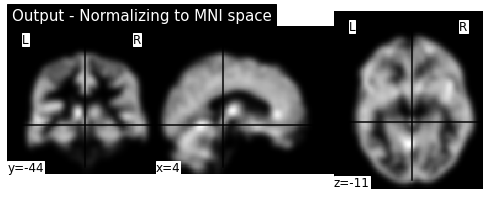

In [59]:
smwc1_structural_1 = nib.load('smwc1structural_1.nii')
plotting.plot_img(smwc1_structural_1,cmap='gray',display_mode='ortho',title='Output - Normalizing to MNI space')

### 🧠 Voxel-based morphometry to study the relationship between aging and gray matter density 

This example is adapted from [Nilearn examples](https://nilearn.github.io/auto_examples/02_decoding/plot_oasis_vbm.html) and the OASIS dataset is used in this example and it has been preprocessed using standard VBM pipeline (as described above) to create VBM maps, which will be used here.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

n_subjects = 100 

oasis_dataset             = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps

age = oasis_dataset.ext_vars['age'].astype(float)

# Split data into training set and test set
from sklearn.model_selection import train_test_split
gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(gray_matter_map_filenames, age, train_size=.6, random_state=0)

# print basic information on the dataset
print('First gray-matter anatomy image (3D) is located at: %s' % oasis_dataset.gray_matter_maps[0])  # 3D data
print('First white-matter anatomy image (3D) is located at: %s'% oasis_dataset.white_matter_maps[0]) # 3D data

First gray-matter anatomy image (3D) is located at: /Users/swapna/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: /Users/swapna/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
From version 0.21, test_size will always complement train_size unless both are specified.


In [61]:
nifti_masker   = NiftiMasker(standardize=False, smoothing_fwhm=2, memory='nilearn_cache')  # cache options
gm_maps_masked = nifti_masker.fit_transform(gm_imgs_train)

# The features with too low between-subject variance are removed using:class:sklearn.feature_selection.VarianceThreshold.

from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=.01)

gm_maps_thresholded = variance_threshold.fit_transform(gm_maps_masked)
gm_maps_masked      = variance_threshold.inverse_transform(gm_maps_thresholded)

# The data is then converted back to the mask image in order to use it for decoding process
mask = nifti_masker.inverse_transform(variance_threshold.get_support())

In [62]:
from nilearn.decoding import DecoderRegressor

decoder = DecoderRegressor(estimator='svr', mask=mask, scoring='neg_mean_absolute_error',
                           screening_percentile=1, n_jobs=1)

# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)


# Sort test data for better visualization (trend, etc.)
perm         = np.argsort(age_test)[::-1]
age_test     = age_test[perm]
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred     = decoder.predict(gm_imgs_test)

prediction_score = -np.mean(decoder.cv_scores_['beta'])

print("=== DECODER ===")
print("explained variance for the cross-validation: %f" % prediction_score)
print("")

=== DECODER ===
explained variance for the cross-validation: 10.670598



Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


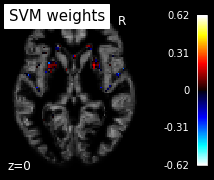

In [63]:
weight_img = decoder.coef_img_['beta']

from nilearn.plotting import plot_stat_map, show

bg_filename = gray_matter_map_filenames[0]

z_slice = 0
display = plot_stat_map(weight_img, bg_img=bg_filename, display_mode='z', cut_coords=[z_slice])
display.title("SVM weights")
show()